In [1]:
import pandas as pd
import re
import string
import nltk

# Download required NLTK data (run this cell once; safe to re-run)
for res in ['stopwords', 'wordnet', 'averaged_perceptron_tagger_eng']:
    try:
        nltk.download(res, quiet=True)
    except Exception:
        if res == 'averaged_perceptron_tagger_eng':
            nltk.download('averaged_perceptron_tagger', quiet=True)
        pass

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

wnl = WordNetLemmatizer()
WORDNET_POS = {'N': 'n', 'V': 'v', 'J': 'a', 'R': 'r'}  # noun, verb, adj, adv

# Five categories' label-specific words and phrases (used only in second pass; first pass does not remove these)
LABEL_SPECIFIC_PHRASES = [
    "adenocarcinoma of the stomach", "stomach cancer", "colon cancer",
    "liver cancer", "bile duct", "lung cancer", "thyroid cancer", "anaplastic thyroid",
]
LABEL_SPECIFIC_WORDS = {
    # Colon
    "colon", "colorectal", "bowel", "intestine", "rectal", "rectum", "sigmoid", "cecum", "caecum", "colonic",
    # Liver
    "liver", "hepatic", "hepatocellular", "hcc", "hepatoma", "hepatoblastoma", "hepato",
    # Lung
    "lung", "pulmonary", "bronchus", "bronchial", "nsclc", "sclc", "alveolar", "thoracic", "pleural",
    # Stomach
    "stomach", "gastric", "gastrointestinal", "cardia", "antrum", "gastrium",
    # Thyroid
    "thyroid", "thyroidal", "thyroidectomy", "papillary", "follicular", "medullary", "goiter",
}

# NLTK English stopwords + custom stopwords (no label-specific words here; those are removed in second pass only)
CUSTOM_STOPWORDS = {
    # XML tag residues
    'abstracttext', 'label', 'jats', 'title', 'introduction', 'methods', 'results', 'conclusions', 'metadata',
    # Publication info
    'copyright', 'published', 'author', 'authors', 'doi', 'journal', 'publication', 'pubmed',
    # Generic research terms
    'cancer', 'cancers', 'disease', 'patient', 'patients', 'study', 'clinical', 'treatment', 'analysis',
}
STOP_WORDS = set(stopwords.words('english')) | CUSTOM_STOPWORDS

In [2]:
# Table: second-pass stopwords (phrases and words removed in unified second pass)
df_phrases = pd.DataFrame({"Type": "phrase", "Term": list(LABEL_SPECIFIC_PHRASES)})
df_words = pd.DataFrame({"Type": "word", "Term": sorted(LABEL_SPECIFIC_WORDS)})
df_second_pass = pd.concat([df_phrases, df_words], ignore_index=True)
print("=== Second-pass stopwords (phrases + words removed in second pass) ===\n")
print(df_second_pass.to_string(index=False))
try:
    display(df_second_pass)
except NameError:
    pass

=== Second-pass stopwords (phrases + words removed in second pass) ===

  Type                          Term
phrase adenocarcinoma of the stomach
phrase                stomach cancer
phrase                  colon cancer
phrase                  liver cancer
phrase                     bile duct
phrase                   lung cancer
phrase                thyroid cancer
phrase            anaplastic thyroid
  word                      alveolar
  word                        antrum
  word                         bowel
  word                     bronchial
  word                      bronchus
  word                        caecum
  word                        cardia
  word                         cecum
  word                         colon
  word                       colonic
  word                    colorectal
  word                    follicular
  word                       gastric
  word                      gastrium
  word              gastrointestinal
  word                        goiter
  w

,Type,Term
0,phrase,adenocarcinoma of the stomach
1,phrase,stomach cancer
2,phrase,colon cancer
3,phrase,liver cancer
4,phrase,bile duct
5,phrase,lung cancer
6,phrase,thyroid cancer
7,phrase,anaplastic thyroid
8,word,alveolar
9,word,antrum


In [3]:
def remove_metadata(text):
    """Remove metadata: DOI block first, then journal names, dates, XML tags."""
    if pd.isna(text) or not isinstance(text, str):
        return ''
    s = text
    # Remove entire DOI block first (e.g. 10.1016/..., DOI: 10.1007/...) before stripping punctuation
    s = re.sub(r'(?i)(?:DOI\s*:\s*)?10\.\d{4,}/[^\s]+', ' ', s)
    # Article numbers (e.g. 1. , 22. )
    s = re.sub(r'\b\d+\.\s+', ' ', s)
    # XML/HTML tags
    s = re.sub(r'<[^>]+>', ' ', s)
    # Copyright (e.g. (c) 2025. The Author(s).)
    s = re.sub(r'©\s*\d{4}[^.]*\.', ' ', s)
    s = re.sub(r'CopyrightInformation[^;]*', ' ', s, flags=re.IGNORECASE)
    # Journal/publication phrases (Published in ... ; Journal of ... ; etc.)
    s = re.sub(r'Published\s+in\s+[^.;]+[\.;]', ' ', s, flags=re.IGNORECASE)
    s = re.sub(r'\bJournal\s+of\s+[^.;]+[\.;]', ' ', s, flags=re.IGNORECASE)
    # Date formats (e.g. January 1, 1995, 1998-2004)
    s = re.sub(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},?\s*\d{4}\b', ' ', s, flags=re.IGNORECASE)
    s = re.sub(r'\b\d{4}-\d{4}\b', ' ', s)
    s = re.sub(r'\b\d{1,2}/\d{1,2}/\d{2,4}\b', ' ', s)
    # Collapse whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    return s


def _wordnet_pos(tag):
    """Map NLTK pos_tag first char to WordNet pos."""
    if not tag:
        return 'n'
    return WORDNET_POS.get(tag[0], 'n')


def standardize_text(text):
    """Standardize: lowercase, remove label phrases, strip punctuation/digits, lemmatize, remove stopwords."""
    if not text or not text.strip():
        return ''
    s = text.lower().strip()
    # Keep only letters and spaces (remove punctuation and digits); label-specific phrases removed in second pass only
    s = re.sub(r'[^a-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # Tokenize -> lemmatize with POS -> drop stopwords
    words = s.split()
    if not words:
        return ''
    # POS tag for lemmatization; fallback to no lemmatization if wordnet/tagger missing
    try:
        tagged = pos_tag(words)
        words = [wnl.lemmatize(w, _wordnet_pos(tag)) for w, tag in tagged]
    except LookupError:
        words = list(words)  # keep words as-is
    words = [w for w in words if w and w not in STOP_WORDS]
    return ' '.join(words)


def clean_cell(text):
    """Run remove_metadata then standardize_text on a single cell."""
    s = remove_metadata(text)
    return standardize_text(s)

In [4]:
# CSV file paths; column to clean: Text (Label kept as-is)
FILES = [
    'Colon_Cancer.csv',
    'Liver_Cancer.csv',
    'Lung_Cancer.csv',
    'Stomach_Cancer.csv',
    'Thyroid_Cancer.csv',
]

TEXT_COLUMNS = ['Text']
OUTPUT_FILE = 'cancer_cleaned.csv'  # single merged output

In [5]:
# Use same config as cell above (definitions here so this cell can run standalone)
FILES = [
    'Colon_Cancer.csv',
    'Liver_Cancer.csv',
    'Lung_Cancer.csv',
    'Stomach_Cancer.csv',
    'Thyroid_Cancer.csv',
]
TEXT_COLUMNS = ['Text']
OUTPUT_FILE = 'cancer_cleaned.csv'

dfs = []
for fname in FILES:
    df = pd.read_csv(fname, encoding='utf-8')
    for col in TEXT_COLUMNS:
        if col in df.columns:
            df[col] = df[col].astype(str).apply(clean_cell)
    dfs.append(df)
    print(f'{fname}: {len(df)} rows')

merged = pd.concat(dfs, ignore_index=True)
merged.to_csv(OUTPUT_FILE, index=False, encoding='utf-8')
print(f'\nMerged -> {OUTPUT_FILE} ({len(merged)} rows total)')

Colon_Cancer.csv: 200 rows
Liver_Cancer.csv: 200 rows
Lung_Cancer.csv: 200 rows
Stomach_Cancer.csv: 200 rows
Thyroid_Cancer.csv: 200 rows

Merged -> cancer_cleaned.csv (1000 rows total)


In [6]:
# Preview first-pass result (merged row 0)
df_orig = pd.read_csv('Colon_Cancer.csv', encoding='utf-8')
df_merged = pd.read_csv(OUTPUT_FILE, encoding='utf-8')
print('=== Original Text (Colon_Cancer row 0, first 300 chars) ===')
print(df_orig['Text'].iloc[0][:300], '...')
print('\n=== Cleaned Text (merged row 0, first 300 chars) ===')
print(df_merged['Text'].iloc[0][:300], '...')
print('\n=== Label (row 0) ===', df_merged['Label'].iloc[0])
print('\n=== Merged shape ===', df_merged.shape)

=== Original Text (Colon_Cancer row 0, first 300 chars) ===
Surgery of colon cancer in a district hospital Colorectal cancer is a common illness and continues even today to be the second cause of death in the U.S.A., after lung cancer. Although the incidence of gastric and pancreatic cancer has declined dramatically in recent years, the incidence of colorect ...

=== Cleaned Text (merged row 0, first 300 chars) ===
surgery colon district hospital colorectal common illness continue even today second cause death u lung although incidence gastric pancreatic decline dramatically recent year incidence colorectal increase aim present experience result surgical technique apply clinic colorectal complication present e ...

=== Label (row 0) === 0

=== Merged shape === (1000, 2)


In [7]:
# Second pass: unified removal (same list for all rows)
# Define here so this cell works even if "Import and stopwords" cell was not run.
import re
LABEL_SPECIFIC_PHRASES = [
    "adenocarcinoma of the stomach", "stomach cancer", "colon cancer",
    "liver cancer", "bile duct", "lung cancer", "thyroid cancer", "anaplastic thyroid",
]
LABEL_SPECIFIC_WORDS = {
    "colon", "colorectal", "bowel", "intestine", "rectal", "rectum", "sigmoid", "cecum", "caecum", "colonic",
    "liver", "hepatic", "hepatocellular", "hcc", "hepatoma", "hepatoblastoma", "hepato",
    "lung", "pulmonary", "bronchus", "bronchial", "nsclc", "sclc", "alveolar", "thoracic", "pleural",
    "stomach", "gastric", "gastrointestinal", "cardia", "antrum", "gastrium",
    "thyroid", "thyroidal", "thyroidectomy", "papillary", "follicular", "medullary", "goiter",
}

def clean_text_unified(text):
    """Remove all label-specific phrases and words from text (whole sample, no per-label logic)."""
    if not text or not str(text).strip():
        return ""
    s = str(text).lower().strip()
    for phrase in LABEL_SPECIFIC_PHRASES:
        s = s.replace(phrase, " ")
    s = re.sub(r"\s+", " ", s).strip()
    words = s.split()
    words = [w for w in words if w not in LABEL_SPECIFIC_WORDS]
    return " ".join(words).strip()

In [8]:
# Read first-pass output, apply second-pass unified cleaning, write cancer_cleaned_v2.csv
# (Definitions below allow this cell to run standalone.)
import pandas as pd
import re

LABEL_SPECIFIC_PHRASES = [
    "adenocarcinoma of the stomach", "stomach cancer", "colon cancer",
    "liver cancer", "bile duct", "lung cancer", "thyroid cancer", "anaplastic thyroid",
]
LABEL_SPECIFIC_WORDS = {
    "colon", "colorectal", "bowel", "intestine", "rectal", "rectum", "sigmoid", "cecum", "caecum", "colonic",
    "liver", "hepatic", "hepatocellular", "hcc", "hepatoma", "hepatoblastoma", "hepato",
    "lung", "pulmonary", "bronchus", "bronchial", "nsclc", "sclc", "alveolar", "thoracic", "pleural",
    "stomach", "gastric", "gastrointestinal", "cardia", "antrum", "gastrium",
    "thyroid", "thyroidal", "thyroidectomy", "papillary", "follicular", "medullary", "goiter",
}

def clean_text_unified(text):
    if not text or not str(text).strip():
        return ""
    s = str(text).lower().strip()
    for phrase in LABEL_SPECIFIC_PHRASES:
        s = s.replace(phrase, " ")
    s = re.sub(r"\s+", " ", s).strip()
    words = s.split()
    words = [w for w in words if w not in LABEL_SPECIFIC_WORDS]
    return " ".join(words).strip()

SECOND_INPUT = 'cancer_cleaned.csv'
OUTPUT_FILE_V2 = 'cancer_cleaned_v2.csv'

df_second = pd.read_csv(SECOND_INPUT, encoding='utf-8')
df_second['Text'] = df_second['Text'].apply(clean_text_unified)
df_second.to_csv(OUTPUT_FILE_V2, index=False, encoding='utf-8')
print(f'Read {len(df_second)} rows from {SECOND_INPUT}')
print(f'Wrote {OUTPUT_FILE_V2}')

Read 1000 rows from cancer_cleaned.csv
Wrote cancer_cleaned_v2.csv


In [9]:
# Preview second-pass result (same row 0)
import pandas as pd
SECOND_INPUT = 'cancer_cleaned.csv'
OUTPUT_FILE_V2 = 'cancer_cleaned_v2.csv'
df_v1 = pd.read_csv(SECOND_INPUT, encoding='utf-8')
df_v2 = pd.read_csv(OUTPUT_FILE_V2, encoding='utf-8')
print('=== After first pass (row 0, first 300 chars) ===')
print(df_v1['Text'].iloc[0][:300], '...')
print('\n=== After second pass (row 0, first 300 chars) ===')
print(df_v2['Text'].iloc[0][:300], '...')
print('\n=== Label (row 0) ===', df_v2['Label'].iloc[0])
print('\n=== cancer_cleaned_v2.csv shape ===', df_v2.shape)

=== After first pass (row 0, first 300 chars) ===
surgery colon district hospital colorectal common illness continue even today second cause death u lung although incidence gastric pancreatic decline dramatically recent year incidence colorectal increase aim present experience result surgical technique apply clinic colorectal complication present e ...

=== After second pass (row 0, first 300 chars) ===
surgery district hospital common illness continue even today second cause death u although incidence pancreatic decline dramatically recent year incidence increase aim present experience result surgical technique apply clinic complication present experience treat five year period treat clinic men me ...

=== Label (row 0) === 0

=== cancer_cleaned_v2.csv shape === (1000, 2)


In [10]:
# Compute minimum word count from cancer_cleaned_v2.csv second column
df_v2 = pd.read_csv('cancer_cleaned_v2.csv', encoding='utf-8')
word_counts = df_v2['Text'].str.split().str.len()
min_words = int(word_counts.min())
print('Minimum words per row (cancer_cleaned_v2.csv, second column):', min_words)
print('Max words per row:', word_counts.max())
print('Mean words per row:', round(word_counts.mean(), 1))


def trim_text_to_n_words(text, n):
    """Keep only the first n words; return space-joined string."""
    if pd.isna(text) or not isinstance(text, str):
        return ''
    words = str(text).split()
    return ' '.join(words[:n]) if len(words) > n else ' '.join(words)


# Trim both CSVs to min_words and save new files
for name, out_name in [
    ('cancer_cleaned.csv', 'cancer_cleaned_trimmed.csv'),
    ('cancer_cleaned_v2.csv', 'cancer_cleaned_v2_trimmed.csv'),
]:
    df = pd.read_csv(name, encoding='utf-8')
    df['Text'] = df['Text'].apply(lambda t: trim_text_to_n_words(t, min_words))
    df.to_csv(out_name, index=False, encoding='utf-8')
    print(f'{name} -> {out_name} (Text trimmed to {min_words} words per row)')

Minimum words per row (cancer_cleaned_v2.csv, second column): 103
Max words per row: 572
Mean words per row: 177.0
cancer_cleaned.csv -> cancer_cleaned_trimmed.csv (Text trimmed to 103 words per row)
cancer_cleaned_v2.csv -> cancer_cleaned_v2_trimmed.csv (Text trimmed to 103 words per row)


In [11]:
import pandas as pd

# Both paths are before trim (裁剪之前); do not use *_trimmed.csv
PATH_BEFORE = 'cancer_cleaned.csv'   # after first pass only, untrimmed
PATH_AFTER = 'cancer_cleaned_v2.csv' # after second pass, untrimmed

df_before = pd.read_csv(PATH_BEFORE, encoding='utf-8')
df_after = pd.read_csv(PATH_AFTER, encoding='utf-8')

wc_before = df_before['Text'].str.split().str.len()
wc_after = df_after['Text'].str.split().str.len()
wc_deleted = wc_before - wc_after

total_before = int(wc_before.sum())
total_after = int(wc_after.sum())
total_deleted = int(wc_deleted.sum())
pct_deleted = 100.0 * total_deleted / total_before if total_before else 0

print('Total words (before second pass):', total_before)
print('Total words (after second pass):', total_after)
print('Words removed by second pass:', total_deleted)
print('Deleted words as % of total (before):', round(pct_deleted, 2), '%')

Total words (before second pass): 188846
Total words (after second pass): 176979
Words removed by second pass: 11867
Deleted words as % of total (before): 6.28 %


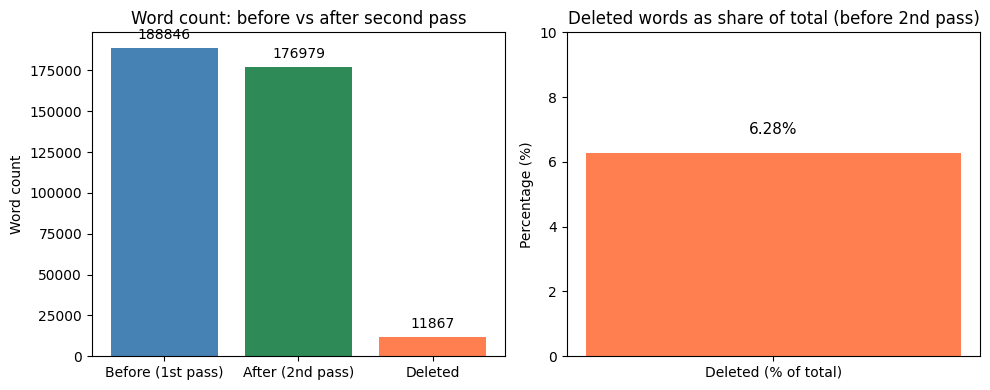

In [12]:
try:
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Left: Before vs After vs Deleted (absolute counts)
    ax1 = axes[0]
    labels = ['Before (1st pass)', 'After (2nd pass)', 'Deleted']
    values = [total_before, total_after, total_deleted]
    colors = ['steelblue', 'seagreen', 'coral']
    bars = ax1.bar(labels, values, color=colors)
    ax1.set_ylabel('Word count')
    ax1.set_title('Word count: before vs after second pass')
    for b, v in zip(bars, values):
        ax1.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02 * max(values), str(v), ha='center', va='bottom', fontsize=10)
    # Right: Proportion of deleted words in the whole (single bar)
    ax2 = axes[1]
    ax2.bar(['Deleted (% of total)'], [pct_deleted], color='coral')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Deleted words as share of total (before 2nd pass)')
    ax2.set_ylim(0, max(pct_deleted * 1.2, 10))
    ax2.text(0, pct_deleted + 0.5, f'{pct_deleted:.2f}%', ha='center', va='bottom', fontsize=11)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("matplotlib not installed. Install with: pip install matplotlib")
    print("\nText-based bars (relative scale):")
    max_val = max(total_before, total_after, total_deleted) or 1
    def text_bar(label, val):
        n = int(50 * val / max_val)
        return f"  {label:20} |{'#' * n} {val}"
    print(text_bar("Before (1st pass)", total_before))
    print(text_bar("After (2nd pass)", total_after))
    print(text_bar("Deleted", total_deleted))
    print(f"\n  Deleted as % of total (before): {pct_deleted:.2f}%")